# Système Unifié de Détection d'Intrusion Réseau avec Ensemble Learning

## Objectif
Créer un système robuste de détection d'intrusion utilisant l'IA avec plusieurs approches :
- **Ensemble Learning** : Combinaison de KNN, MLP, XGBoost, Random Forest, SVM
- **Stacking** : Meta-modèle pour optimiser les prédictions
- **Approche Hybride** : Détection par signature + détection d'anomalies
- **Dataset** : UNSW-NB15 pour la détection d'attaques réseau

## Architecture du Système
1. **Modèles de Base** : KNN, MLP, XGBoost, Random Forest, SVM, Isolation Forest
2. **Meta-Modèle** : Logistic Regression pour le stacking
3. **Stratégies de Vote** : Majoritaire, pondéré, adaptatif
4. **Système Hybride** : Combinaison détection + anomalies

## Plan de Développement
1. **Analyse et Préparation des Données** : Chargement, nettoyage, et préprocessing des données UNSW-NB15
2. **Modélisation** : Création et entraînement des modèles de base et meta-modèle
3. **Ensemble Learning** : Implémentation des stratégies d'ensemble et de stacking
4. **Système Hybride** : Intégration de la détection par signature et par anomalies
5. **Évaluation** : Tests et validation du système avec des métriques complètes
6. **Déploiement** : Préparation du système pour une utilisation en production

## État Actuel
- **Données** : Chargées et prétraitées avec succès
- **Modèles** : KNN, MLP, XGBoost, Random Forest, SVM, Isolation Forest créés
- **Ensemble Learning** : Implémenté avec succès
- **Système Hybride** : Développé et intégré
- **Évaluation** : En cours avec des résultats prometteurs

## Prochaines Étapes
1. Finaliser l'évaluation du système hybride
2. Générer des rapports de performance détaillés
3. Optimiser les modèles et le système en fonction des résultats
4. Préparer le déploiement et l'intégration continue
5. Documentation complète du système et des processus

## Conclusion
Ce projet vise à créer un système de détection d'intrusion réseau avancé, capable de s'adapter et d'évoluer face à des menaces variées. Grâce à l'utilisation de l'apprentissage automatique et des techniques d'ensemble, nous visons à atteindre une précision et une fiabilité élevées dans la détection des attaques.

## 1. Chargement et Préprocessing des Données

In [4]:
# Imports essentiels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import pickle
from pathlib import Path
import os
from datetime import datetime
import time

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)

# Modèles individuels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Ensemble methods
from sklearn.ensemble import VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Imports réalisés avec succès")
print(f"📅 Début de l'analyse : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Imports réalisés avec succès
📅 Début de l'analyse : 2025-06-02 01:36:37


In [5]:
# Chargement des données UNSW-NB15
print("🔄 Chargement des données UNSW-NB15...")

# Charger le dataset
try:
    data = pd.read_csv('UNSW_NB15_training-set.csv')
    print(f"✅ Données chargées : {data.shape[0]} échantillons, {data.shape[1]} caractéristiques")
except FileNotFoundError:
    print("❌ Fichier UNSW_NB15_training-set.csv non trouvé")
    print("Veuillez vous assurer que le fichier est dans le répertoire courant")
    raise

# Affichage des informations de base
print("\n📊 Informations sur le dataset :")
print(f"  • Forme : {data.shape}")
print(f"  • Colonnes : {list(data.columns)}")
print(f"  • Types de données : \n{data.dtypes.value_counts()}")
print(f"  • Valeurs manquantes : {data.isnull().sum().sum()}")

# Analyse de la variable cible
if 'label' in data.columns:
    target_col = 'label'
elif 'Label' in data.columns:
    target_col = 'Label'
elif 'attack_cat' in data.columns:
    target_col = 'attack_cat'
else:
    # Chercher automatiquement
    potential_targets = [col for col in data.columns if any(keyword in col.lower() for keyword in ['label', 'class', 'target', 'attack'])]
    target_col = potential_targets[0] if potential_targets else data.columns[-1]
    
print(f"\n🎯 Variable cible détectée : '{target_col}'")
print(f"  • Distribution : \n{data[target_col].value_counts()}")

# Aperçu des données
print("\n👀 Aperçu des données :")
display(data.head())
print("\n📈 Statistiques descriptives :")
display(data.describe())

🔄 Chargement des données UNSW-NB15...
✅ Données chargées : 82332 échantillons, 45 caractéristiques

📊 Informations sur le dataset :
  • Forme : (82332, 45)
  • Colonnes : ['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label']
  • Types de données : 
int64      30
float64    11
object      4
Name: count, dtype: int64
  • Valeurs manquantes : 0

🎯 Variable cible détectée : 'label'
  • Distribution : 
label
1    45332
0    37000
Name: count, dtype: int64

👀 Aperçu des données :
✅ Données chargées : 82332 échantillons, 45 caractéristiqu

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0



📈 Statistiques descriptives :


,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,82332.000000,8.233200e+04,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,41166.500000,1.006756,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,180.967667,95.713003,6.454902e+07,...,4.928898,3.663011,7.456360,0.008284,0.008381,0.129743,6.468360,9.164262,0.011126,0.550600
std,23767.345519,4.710444,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,101.513358,116.667722,1.798618e+08,...,8.389545,5.915386,11.415191,0.091171,0.092485,0.638683,8.543927,11.121413,0.104891,0.497436
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20583.750000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,62.000000,0.000000,1.120247e+04,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,41166.500000,0.014138,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,254.000000,29.000000,5.770032e+05,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000
75%,61749.250000,0.719360,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,254.000000,252.000000,6.514286e+07,...,4.000000,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,1.000000
max,82332.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,253.000000,5.268000e+09,...,59.000000,38.000000,63.000000,2.000000,2.000000,16.000000,60.000000,62.000000,1.000000,1.000000


## 2. Preprocessing et Feature Engineering

In [6]:
# Preprocessing des données
print("🔄 Preprocessing des données...")

# Copie des données pour le preprocessing
data_processed = data.copy()

# 1. Nettoyage des données
print("\n🧹 Nettoyage des données...")

# Supprimer les colonnes non utiles (si elles existent)
columns_to_drop = ['id', 'ID', 'Unnamed: 0'] 
for col in columns_to_drop:
    if col in data_processed.columns:
        data_processed.drop(col, axis=1, inplace=True)
        print(f"  ✅ Colonne '{col}' supprimée")

# Gérer les valeurs manquantes
missing_values = data_processed.isnull().sum()
if missing_values.sum() > 0:
    print(f"  ⚠️ Valeurs manquantes détectées : {missing_values.sum()}")
    # Remplir les valeurs manquantes numériques par la médiane
    numeric_cols = data_processed.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if data_processed[col].isnull().sum() > 0:
            data_processed[col].fillna(data_processed[col].median(), inplace=True)
    
    # Remplir les valeurs manquantes catégorielles par le mode
    categorical_cols = data_processed.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if data_processed[col].isnull().sum() > 0:
            data_processed[col].fillna(data_processed[col].mode()[0], inplace=True)
    print("  ✅ Valeurs manquantes traitées")
else:
    print("  ✅ Aucune valeur manquante")

# 2. Encodage des variables catégorielles
print("\n🔤 Encodage des variables catégorielles...")
label_encoders = {}
categorical_columns = data_processed.select_dtypes(include=['object']).columns
categorical_columns = [col for col in categorical_columns if col != target_col]

for col in categorical_columns:
    le = LabelEncoder()
    data_processed[col] = le.fit_transform(data_processed[col].astype(str))
    label_encoders[col] = le
    print(f"  ✅ Colonne '{col}' encodée ({len(le.classes_)} classes)")

# 3. Préparation de la variable cible
print("\n🎯 Préparation de la variable cible...")

# Convertir la variable cible en binaire si nécessaire
if data_processed[target_col].dtype == 'object':
    # Si c'est du texte, encoder
    target_encoder = LabelEncoder()
    y = target_encoder.fit_transform(data_processed[target_col])
    print(f"  ✅ Variable cible encodée : {dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))}")
else:
    y = data_processed[target_col].values
    target_encoder = None

# Si plus de 2 classes, convertir en binaire (normal=0, attaque=1)
if len(np.unique(y)) > 2:
    y_binary = (y != 0).astype(int)  # Supposer que 0 = normal, reste = attaque
    print(f"  ✅ Conversion en binaire : Normal={np.sum(y_binary==0)}, Attaque={np.sum(y_binary==1)}")
    y = y_binary

# 4. Séparation des features
X = data_processed.drop(target_col, axis=1)
feature_names = X.columns.tolist()

print(f"\n📊 Données préparées :")
print(f"  • Features : {X.shape[1]} colonnes")
print(f"  • Échantillons : {X.shape[0]}")
print(f"  • Distribution cible : Normal={np.sum(y==0)}, Attaque={np.sum(y==1)}")
print(f"  • Types de features : {X.dtypes.value_counts().to_dict()}")

# 5. Normalisation des données
print("\n📏 Normalisation des données...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Preprocessing terminé avec succès")
print(f"  • Forme finale de X : {X_scaled.shape}")
print(f"  • Forme finale de y : {y.shape}")

🔄 Preprocessing des données...

🧹 Nettoyage des données...
  ✅ Colonne 'id' supprimée
  ✅ Aucune valeur manquante

🔤 Encodage des variables catégorielles...
  ✅ Colonne 'proto' encodée (131 classes)
  ✅ Colonne 'service' encodée (13 classes)
  ✅ Colonne 'state' encodée (7 classes)
  ✅ Colonne 'service' encodée (13 classes)
  ✅ Colonne 'state' encodée (7 classes)
  ✅ Colonne 'attack_cat' encodée (10 classes)

🎯 Préparation de la variable cible...

📊 Données préparées :
  • Features : 43 colonnes
  • Échantillons : 82332
  • Distribution cible : Normal=37000, Attaque=45332
  • Types de features : {dtype('int64'): 32, dtype('float64'): 11}

📏 Normalisation des données...
✅ Preprocessing terminé avec succès
  • Forme finale de X : (82332, 43)
  • Forme finale de y : (82332,)
  ✅ Colonne 'attack_cat' encodée (10 classes)

🎯 Préparation de la variable cible...

📊 Données préparées :
  • Features : 43 colonnes
  • Échantillons : 82332
  • Distribution cible : Normal=37000, Attaque=45332
  • T

## 3. Division des Données

In [7]:
# Division des données en ensembles d'entraînement, validation et test
print("🔄 Division des données...")

# Premier split : train+val (80%) et test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Deuxième split : train (60%) et val (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"📊 Division terminée :")
print(f"  • Train : {X_train.shape[0]} échantillons ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  • Validation : {X_val.shape[0]} échantillons ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  • Test : {X_test.shape[0]} échantillons ({X_test.shape[0]/len(X)*100:.1f}%)")

# Vérification de la distribution des classes
print(f"\n📈 Distribution des classes :")
print(f"  • Train - Normal: {np.sum(y_train==0)}, Attaque: {np.sum(y_train==1)}")
print(f"  • Val - Normal: {np.sum(y_val==0)}, Attaque: {np.sum(y_val==1)}")
print(f"  • Test - Normal: {np.sum(y_test==0)}, Attaque: {np.sum(y_test==1)}")

# Préparation du dictionnaire des splits pour faciliter l'utilisation
data_splits = {
    'X_train': X_train,
    'X_val': X_val,
    'X_test': X_test,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test,
    'feature_names': feature_names,
    'scaler': scaler,
    'label_encoders': label_encoders
}

print("✅ Données prêtes pour l'entraînement des modèles")

🔄 Division des données...
📊 Division terminée :
  • Train : 49398 échantillons (60.0%)
  • Validation : 16467 échantillons (20.0%)
  • Test : 16467 échantillons (20.0%)

📈 Distribution des classes :
  • Train - Normal: 22200, Attaque: 27198
  • Val - Normal: 7400, Attaque: 9067
  • Test - Normal: 7400, Attaque: 9067
✅ Données prêtes pour l'entraînement des modèles
📊 Division terminée :
  • Train : 49398 échantillons (60.0%)
  • Validation : 16467 échantillons (20.0%)
  • Test : 16467 échantillons (20.0%)

📈 Distribution des classes :
  • Train - Normal: 22200, Attaque: 27198
  • Val - Normal: 7400, Attaque: 9067
  • Test - Normal: 7400, Attaque: 9067
✅ Données prêtes pour l'entraînement des modèles


## 4. Chargement des Modèles Existants

In [8]:
# Chargement des modèles pré-entraînés
print("🔄 Chargement des modèles existants...")

existing_models = {}
model_files = {
    'KNN': 'models/KNN_best.pkl',
    'MLP': 'models/mlp_best.pkl', 
    'XGBoost': 'models/xgb_best.pkl'
}

loaded_models = []
for model_name, file_path in model_files.items():
    try:
        if os.path.exists(file_path):
            model = joblib.load(file_path)
            existing_models[model_name] = model
            loaded_models.append(model_name)
            print(f"  ✅ {model_name} chargé depuis {file_path}")
        else:
            print(f"  ⚠️ {file_path} non trouvé")
    except Exception as e:
        print(f"  ❌ Erreur lors du chargement de {model_name}: {e}")

# Chargement des scalers et encoders existants si disponibles
try:
    if os.path.exists('models/scaler.pkl'):
        existing_scaler = joblib.load('models/scaler.pkl')
        print("  ✅ Scaler existant chargé")
    else:
        existing_scaler = None
        print("  ⚠️ Aucun scaler existant trouvé")
except:
    existing_scaler = None
    print("  ❌ Erreur lors du chargement du scaler")

print(f"\n📊 Modèles chargés : {len(loaded_models)}/{len(model_files)}")
print(f"  • Modèles disponibles : {loaded_models}")

# Création de modèles additionnels pour l'ensemble
print("\n🔄 Création de modèles additionnels...")

additional_models = {}

# Random Forest
print("  🌳 Création Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
additional_models['RandomForest'] = rf_model

# SVM
print("  🎯 Création SVM...")
svm_model = SVC(
    kernel='rbf',
    probability=True,
    random_state=42
)
additional_models['SVM'] = svm_model

# Gradient Boosting (XGBoost alternatif)
if 'XGBoost' not in existing_models:
    print("  🚀 Création XGBoost...")
    xgb_model = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        eval_metric='logloss'
    )
    additional_models['XGBoost'] = xgb_model

# Détecteur d'anomalies
print("  🔍 Création détecteur d'anomalies...")
anomaly_detector = IsolationForest(
    contamination=0.1,
    random_state=42,
    n_jobs=-1
)

print(f"\n✅ Modèles préparés :")
print(f"  • Modèles existants : {list(existing_models.keys())}")
print(f"  • Modèles additionnels : {list(additional_models.keys())}")
print(f"  • Détecteur d'anomalies : Isolation Forest")

🔄 Chargement des modèles existants...
  ✅ KNN chargé depuis models/KNN_best.pkl
  ✅ MLP chargé depuis models/mlp_best.pkl
  ✅ XGBoost chargé depuis models/xgb_best.pkl
  ✅ Scaler existant chargé

📊 Modèles chargés : 3/3
  • Modèles disponibles : ['KNN', 'MLP', 'XGBoost']

🔄 Création de modèles additionnels...
  🌳 Création Random Forest...
  🎯 Création SVM...
  🔍 Création détecteur d'anomalies...

✅ Modèles préparés :
  • Modèles existants : ['KNN', 'MLP', 'XGBoost']
  • Modèles additionnels : ['RandomForest', 'SVM']
  • Détecteur d'anomalies : Isolation Forest
  ✅ XGBoost chargé depuis models/xgb_best.pkl
  ✅ Scaler existant chargé

📊 Modèles chargés : 3/3
  • Modèles disponibles : ['KNN', 'MLP', 'XGBoost']

🔄 Création de modèles additionnels...
  🌳 Création Random Forest...
  🎯 Création SVM...
  🔍 Création détecteur d'anomalies...

✅ Modèles préparés :
  • Modèles existants : ['KNN', 'MLP', 'XGBoost']
  • Modèles additionnels : ['RandomForest', 'SVM']
  • Détecteur d'anomalies : Isola

## 4.5. Classe AdvancedEnsembleClassifier

In [9]:
class AdvancedEnsembleClassifier:
    """
    Classificateur d'ensemble avancé avec multiple stratégies de vote et stacking
    """
    
    def __init__(self, base_models=None, meta_model=None, voting_strategy='soft'):
        self.base_models = base_models or {}
        self.meta_model = meta_model or LogisticRegression(random_state=42)
        self.voting_strategy = voting_strategy
        self.is_fitted = False
        self.model_weights = None
        self.stacking_classifier = None
        
    def add_model(self, name, model):
        """Ajoute un modèle à l'ensemble"""
        self.base_models[name] = model
        
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """Entraîne l'ensemble de modèles"""
        print(f"🔄 Entraînement de l'ensemble ({len(self.base_models)} modèles)...")
        
        # Entraînement des modèles de base
        for name, model in self.base_models.items():
            print(f"  📈 Entraînement {name}...")
            try:
                model.fit(X_train, y_train)
                print(f"    ✅ {name} entraîné")
            except Exception as e:
                print(f"    ❌ Erreur {name}: {e}")
                
        # Calcul des poids basés sur la performance de validation
        if X_val is not None and y_val is not None:
            self._calculate_model_weights(X_val, y_val)
            
        # Création du stacking classifier
        self._create_stacking_classifier(X_train, y_train)
        
        self.is_fitted = True
        print("✅ Ensemble entraîné")
        
    def _calculate_model_weights(self, X_val, y_val):
        """Calcule les poids des modèles basés sur leur performance"""
        print("  ⚖️ Calcul des poids des modèles...")
        weights = {}
        
        for name, model in self.base_models.items():
            try:
                y_pred = model.predict(X_val)
                f1 = f1_score(y_val, y_pred, average='weighted')
                weights[name] = f1
                print(f"    📊 {name}: F1-Score = {f1:.4f}")
            except Exception as e:
                print(f"    ❌ Erreur calcul poids {name}: {e}")
                weights[name] = 0.1
                
        # Normalisation des poids
        total_weight = sum(weights.values())
        if total_weight > 0:
            self.model_weights = {k: v/total_weight for k, v in weights.items()}
        else:
            self.model_weights = {k: 1/len(weights) for k in weights.keys()}
            
        print(f"    ✅ Poids calculés : {dict(zip(self.model_weights.keys(), [f'{v:.3f}' for v in self.model_weights.values()]))}")
        
    def _create_stacking_classifier(self, X_train, y_train):
        """Crée le classificateur de stacking"""
        print("  🏗️ Création du stacking classifier...")
        
        try:
            # Préparer les estimateurs pour le stacking
            estimators = [(name, model) for name, model in self.base_models.items()]
            
            self.stacking_classifier = StackingClassifier(
                estimators=estimators,
                final_estimator=self.meta_model,
                cv=3,
                n_jobs=-1
            )
            
            self.stacking_classifier.fit(X_train, y_train)
            print("    ✅ Stacking classifier créé et entraîné")
            
        except Exception as e:
            print(f"    ❌ Erreur stacking: {e}")
            self.stacking_classifier = None
            
    def predict(self, X, strategy='weighted_voting'):
        """Fait des prédictions avec la stratégie spécifiée"""
        if not self.is_fitted:
            raise ValueError("L'ensemble doit être entraîné")
            
        if strategy == 'majority_voting':
            return self._predict_majority_voting(X)
        elif strategy == 'weighted_voting':
            return self._predict_weighted_voting(X)
        elif strategy == 'soft_voting':
            return self._predict_soft_voting(X)
        elif strategy == 'stacking' and self.stacking_classifier:
            return self.stacking_classifier.predict(X)
        else:
            return self._predict_weighted_voting(X)  # Par défaut
            
    def predict_proba(self, X, strategy='weighted_voting'):
        """Prédit les probabilités avec la stratégie spécifiée"""
        if not self.is_fitted:
            raise ValueError("L'ensemble doit être entraîné")
            
        if strategy == 'stacking' and self.stacking_classifier:
            return self.stacking_classifier.predict_proba(X)
        else:
            return self._predict_proba_ensemble(X)
            
    def _predict_majority_voting(self, X):
        """Vote majoritaire"""
        predictions = []
        for name, model in self.base_models.items():
            try:
                pred = model.predict(X)
                predictions.append(pred)
            except:
                continue
                
        if predictions:
            predictions = np.array(predictions)
            return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
        else:
            return np.zeros(len(X))
            
    def _predict_weighted_voting(self, X):
        """Vote pondéré"""
        if not self.model_weights:
            return self._predict_majority_voting(X)
            
        weighted_predictions = np.zeros(len(X))
        total_weight = 0
        
        for name, model in self.base_models.items():
            if name in self.model_weights:
                try:
                    pred = model.predict(X)
                    weight = self.model_weights[name]
                    weighted_predictions += pred * weight
                    total_weight += weight
                except:
                    continue
                    
        if total_weight > 0:
            return (weighted_predictions / total_weight > 0.5).astype(int)
        else:
            return self._predict_majority_voting(X)
            
    def _predict_soft_voting(self, X):
        """Vote soft (basé sur les probabilités)"""
        probabilities = self._predict_proba_ensemble(X)
        if probabilities is not None:
            return (probabilities[:, 1] > 0.5).astype(int)
        else:
            return self._predict_majority_voting(X)
            
    def _predict_proba_ensemble(self, X):
        """Calcule les probabilités moyennes de l'ensemble"""
        all_probas = []
        weights = []
        
        for name, model in self.base_models.items():
            if hasattr(model, 'predict_proba'):
                try:
                    proba = model.predict_proba(X)
                    all_probas.append(proba)
                    weight = self.model_weights.get(name, 1.0) if self.model_weights else 1.0
                    weights.append(weight)
                except:
                    continue
                    
        if all_probas:
            # Moyenne pondérée des probabilités
            weighted_probas = np.zeros_like(all_probas[0])
            total_weight = sum(weights)
            
            for i, (proba, weight) in enumerate(zip(all_probas, weights)):
                weighted_probas += proba * (weight / total_weight)
                
            return weighted_probas
        else:
            return None
            
    def get_model_performance(self, X_test, y_test):
        """Évalue la performance de chaque modèle individuellement"""
        performances = {}
        
        for name, model in self.base_models.items():
            try:
                y_pred = model.predict(X_test)
                performance = {
                    'accuracy': accuracy_score(y_test, y_pred),
                    'precision': precision_score(y_test, y_pred, average='weighted'),
                    'recall': recall_score(y_test, y_pred, average='weighted'),
                    'f1': f1_score(y_test, y_pred, average='weighted')
                }
                performances[name] = performance
            except Exception as e:
                print(f"Erreur évaluation {name}: {e}")
                
        return performances

print("✅ Classe AdvancedEnsembleClassifier créée")

✅ Classe AdvancedEnsembleClassifier créée


## 5. Système Hybride de Détection

In [10]:
class HybridDetectionSystem:
    """
    Système hybride combinant détection par signature et détection d'anomalies
    """
    
    def __init__(self, ensemble_classifier, anomaly_detector, threshold=0.5):
        self.ensemble_classifier = ensemble_classifier
        self.anomaly_detector = anomaly_detector
        self.threshold = threshold
        self.is_fitted = False
        
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """Entraîne le système hybride"""
        print("🔄 Entraînement du système hybride...")
        
        # Entraînement du classificateur d'ensemble
        print("  📈 Entraînement du classificateur d'ensemble...")
        self.ensemble_classifier.fit(X_train, y_train, X_val, y_val)
        
        # Entraînement du détecteur d'anomalies
        print("  🔍 Entraînement du détecteur d'anomalies...")
        normal_data = X_train[y_train == 0] if np.any(y_train == 0) else X_train
        
        if len(normal_data) > 0:
            self.anomaly_detector.fit(normal_data)
            print(f"    ✅ Détecteur d'anomalies entraîné sur {len(normal_data)} échantillons")
        else:
            self.anomaly_detector.fit(X_train)
            print(f"    ⚠️ Détecteur d'anomalies entraîné sur {len(X_train)} échantillons")
        
        self.is_fitted = True
        print("✅ Système hybride entraîné")
        
    def predict(self, X, strategy='hybrid'):
        """Fait des prédictions avec le système hybride"""
        if not self.is_fitted:
            raise ValueError("Le système doit être entraîné")
        
        if strategy == 'ensemble_only':
            return self.ensemble_classifier.predict(X)
        elif strategy == 'anomaly_only':
            anomaly_scores = self.anomaly_detector.predict(X)
            return (anomaly_scores == -1).astype(int)
        else:  # strategy == 'hybrid'
            return self._predict_hybrid(X)
    
    def _predict_hybrid(self, X):
        """Prédiction hybride"""
        ensemble_pred = self.ensemble_classifier.predict(X)
        ensemble_proba = self.ensemble_classifier.predict_proba(X)
        anomaly_scores = self.anomaly_detector.predict(X)
        
        hybrid_predictions = []
        
        for i in range(len(X)):
            ensemble_confidence = np.max(ensemble_proba[i]) if ensemble_proba is not None else 0.5
            is_anomaly = anomaly_scores[i] == -1
            
            if ensemble_confidence > self.threshold and not is_anomaly:
                hybrid_predictions.append(ensemble_pred[i])
            elif is_anomaly:
                hybrid_predictions.append(1)  # Attaque
            else:
                hybrid_predictions.append(ensemble_pred[i])
        
        return np.array(hybrid_predictions)

print("✅ Classe HybridDetectionSystem créée")

✅ Classe HybridDetectionSystem créée



## 6. Fonctions d'Évaluation

In [11]:
def evaluate_model_comprehensive(model, X_test, y_test, model_name="Model", strategy=None):
    """Évaluation complète d'un modèle"""
    print(f"📊 Évaluation de {model_name}...")
    
    start_time = time.time()
    
    if hasattr(model, 'predict') and strategy:
        y_pred = model.predict(X_test, strategy=strategy)
    else:
        y_pred = model.predict(X_test)
    
    prediction_time = time.time() - start_time
    
    # Probabilités si disponibles
    y_proba = None
    if hasattr(model, 'predict_proba'):
        try:
            if strategy:
                y_proba = model.predict_proba(X_test, strategy=strategy)
            else:
                y_proba = model.predict_proba(X_test)
        except:
            y_proba = None
    
    # Métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    results = {
        'model_name': model_name,
        'strategy': strategy,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'prediction_time': prediction_time,
        'predictions': y_pred,
        'probabilities': y_proba
    }
    
    # AUC si probabilités disponibles
    if y_proba is not None and y_proba.shape[1] > 1:
        try:
            auc = roc_auc_score(y_test, y_proba[:, 1])
            results['auc'] = auc
        except:
            results['auc'] = None
    else:
        results['auc'] = None
    
    print(f"  ✅ {model_name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Time: {prediction_time:.2f}s")
    
    return results

def compare_ensemble_strategies(ensemble_model, X_test, y_test):
    """Compare différentes stratégies d'ensemble"""
    print("🔄 Comparaison des stratégies d'ensemble...")
    
    strategies = ['majority_voting', 'weighted_voting', 'soft_voting', 'stacking']
    results = {}
    
    for strategy in strategies:
        try:
            result = evaluate_model_comprehensive(
                ensemble_model, X_test, y_test, 
                f"Ensemble ({strategy})", strategy
            )
            results[strategy] = result
        except Exception as e:
            print(f"  ❌ Erreur avec {strategy}: {e}")
            results[strategy] = None
    
    return results

def plot_comparison_results(results, save_path=None):
    """Visualise les résultats de comparaison"""
    print("📈 Génération des graphiques de comparaison...")
    
    # Préparer les données
    models = []
    accuracies = []
    f1_scores = []
    
    for name, result in results.items():
        if result and result.get('accuracy') is not None:
            display_name = result.get('strategy', name) or name
            models.append(f"{result['model_name']} ({display_name})" if result.get('strategy') else result['model_name'])
            accuracies.append(result['accuracy'])
            f1_scores.append(result['f1_score'])
    
    if not models:
        print("  ⚠️ Aucune donnée disponible pour la visualisation")
        return
    
    # Créer les graphiques
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Graphique Accuracy
    bars1 = ax1.bar(range(len(models)), accuracies, color='skyblue', alpha=0.7)
    ax1.set_title('Accuracy par Modèle')
    ax1.set_ylabel('Accuracy')
    ax1.set_xticks(range(len(models)))
    ax1.set_xticklabels(models, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    
    # Ajouter les valeurs sur les barres
    for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{acc:.3f}', ha='center', va='bottom')
    
    # Graphique F1-Score
    bars2 = ax2.bar(range(len(models)), f1_scores, color='lightcoral', alpha=0.7)
    ax2.set_title('F1-Score par Modèle')
    ax2.set_ylabel('F1-Score')
    ax2.set_xticks(range(len(models)))
    ax2.set_xticklabels(models, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    # Ajouter les valeurs sur les barres
    for i, (bar, f1) in enumerate(zip(bars2, f1_scores)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{f1:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"  💾 Graphique sauvegardé : {save_path}")
    
    plt.show()
    
print("✅ Fonctions d'évaluation créées")

✅ Fonctions d'évaluation créées


## 7. Entraînement et Analyse du Système Complet

In [12]:
# 🚀 EXÉCUTION PRINCIPALE - Entraînement et Analyse du Système Complet
print("🚀 DÉMARRAGE DE L'ANALYSE COMPLÈTE")
print("=" * 60)

# 1. Créer l'ensemble de modèles
print("\n🔧 Création de l'ensemble de modèles...")
ensemble_classifier = AdvancedEnsembleClassifier()

# Ajouter tous les modèles disponibles
all_models = {**existing_models, **additional_models}
for name, model in all_models.items():
    ensemble_classifier.add_model(name, model)
    print(f"  ✅ {name} ajouté à l'ensemble")

# 2. Entraîner l'ensemble
print(f"\n🔄 Entraînement de l'ensemble ({len(all_models)} modèles)...")
ensemble_classifier.fit(X_train, y_train, X_val, y_val)

# 3. Créer le système hybride
print("\n🔧 Création du système hybride...")
hybrid_system = HybridDetectionSystem(
    ensemble_classifier=ensemble_classifier,
    anomaly_detector=anomaly_detector,
    threshold=0.6
)

# 4. Entraîner le système hybride
print("\n🔄 Entraînement du système hybride...")
hybrid_system.fit(X_train, y_train, X_val, y_val)

print("\n✅ SYSTÈME COMPLET ENTRAÎNÉ")
print("=" * 60)

🚀 DÉMARRAGE DE L'ANALYSE COMPLÈTE

🔧 Création de l'ensemble de modèles...
  ✅ KNN ajouté à l'ensemble
  ✅ MLP ajouté à l'ensemble
  ✅ XGBoost ajouté à l'ensemble
  ✅ RandomForest ajouté à l'ensemble
  ✅ SVM ajouté à l'ensemble

🔄 Entraînement de l'ensemble (5 modèles)...
🔄 Entraînement de l'ensemble (5 modèles)...
  📈 Entraînement KNN...
    ✅ KNN entraîné
  📈 Entraînement MLP...
    ✅ KNN entraîné
  📈 Entraînement MLP...
    ✅ MLP entraîné
  📈 Entraînement XGBoost...
    ✅ MLP entraîné
  📈 Entraînement XGBoost...
    ✅ XGBoost entraîné
  📈 Entraînement RandomForest...
    ✅ XGBoost entraîné
  📈 Entraînement RandomForest...
    ✅ RandomForest entraîné
  📈 Entraînement SVM...
    ✅ RandomForest entraîné
  📈 Entraînement SVM...
    ✅ SVM entraîné
  ⚖️ Calcul des poids des modèles...
    ✅ SVM entraîné
  ⚖️ Calcul des poids des modèles...
    📊 KNN: F1-Score = 0.9961
    📊 MLP: F1-Score = 0.9999
    📊 XGBoost: F1-Score = 1.0000
    📊 RandomForest: F1-Score = 0.9996
    📊 KNN: F1-Score = 0

In [13]:
# 📊 ÉVALUATION COMPLÈTE DU SYSTÈME
print("\n📊 ÉVALUATION COMPLÈTE DU SYSTÈME")
print("=" * 60)

# Créer le dossier de résultats
os.makedirs('results', exist_ok=True)
os.makedirs('figures/ensemble', exist_ok=True)

all_results = {}

# 1. Évaluer les modèles individuels
print("\n🔍 Évaluation des modèles individuels...")
for name, model in all_models.items():
    try:
        result = evaluate_model_comprehensive(model, X_test, y_test, name)
        all_results[f"Individual_{name}"] = result
    except Exception as e:
        print(f"  ❌ Erreur avec {name}: {e}")

# 2. Évaluer les stratégies d'ensemble
print("\n🔍 Évaluation des stratégies d'ensemble...")
ensemble_results = compare_ensemble_strategies(ensemble_classifier, X_test, y_test)
all_results.update({f"Ensemble_{k}": v for k, v in ensemble_results.items() if v})

# 3. Évaluer le système hybride
print("\n🔍 Évaluation du système hybride...")
hybrid_strategies = ['ensemble_only', 'anomaly_only', 'hybrid']
for strategy in hybrid_strategies:
    try:
        result = evaluate_model_comprehensive(
            hybrid_system, X_test, y_test, 
            f"Hybrid System", strategy
        )
        all_results[f"Hybrid_{strategy}"] = result
    except Exception as e:
        print(f"  ❌ Erreur avec système hybride ({strategy}): {e}")

print(f"\n✅ Évaluation terminée - {len(all_results)} modèles évalués")


📊 ÉVALUATION COMPLÈTE DU SYSTÈME

🔍 Évaluation des modèles individuels...
📊 Évaluation de KNN...
  ✅ KNN - Accuracy: 0.9967, F1: 0.9967, Time: 54.16s
📊 Évaluation de MLP...
  ✅ MLP - Accuracy: 0.9999, F1: 0.9999, Time: 0.03s
📊 Évaluation de XGBoost...
  ✅ XGBoost - Accuracy: 1.0000, F1: 1.0000, Time: 0.01s
📊 Évaluation de RandomForest...
  ✅ KNN - Accuracy: 0.9967, F1: 0.9967, Time: 54.16s
📊 Évaluation de MLP...
  ✅ MLP - Accuracy: 0.9999, F1: 0.9999, Time: 0.03s
📊 Évaluation de XGBoost...
  ✅ XGBoost - Accuracy: 1.0000, F1: 1.0000, Time: 0.01s
📊 Évaluation de RandomForest...
  ✅ RandomForest - Accuracy: 0.9998, F1: 0.9998, Time: 0.04s
📊 Évaluation de SVM...
  ✅ RandomForest - Accuracy: 0.9998, F1: 0.9998, Time: 0.04s
📊 Évaluation de SVM...
  ✅ SVM - Accuracy: 0.9934, F1: 0.9934, Time: 13.20s

🔍 Évaluation des stratégies d'ensemble...
🔄 Comparaison des stratégies d'ensemble...
📊 Évaluation de Ensemble (majority_voting)...
  ✅ SVM - Accuracy: 0.9934, F1: 0.9934, Time: 13.20s

🔍 Évaluat


📈 GÉNÉRATION DES VISUALISATIONS ET RAPPORT FINAL

📊 Génération des graphiques...
📈 Génération des graphiques de comparaison...
  💾 Graphique sauvegardé : figures/ensemble/model_comparison.png
  💾 Graphique sauvegardé : figures/ensemble/model_comparison.png


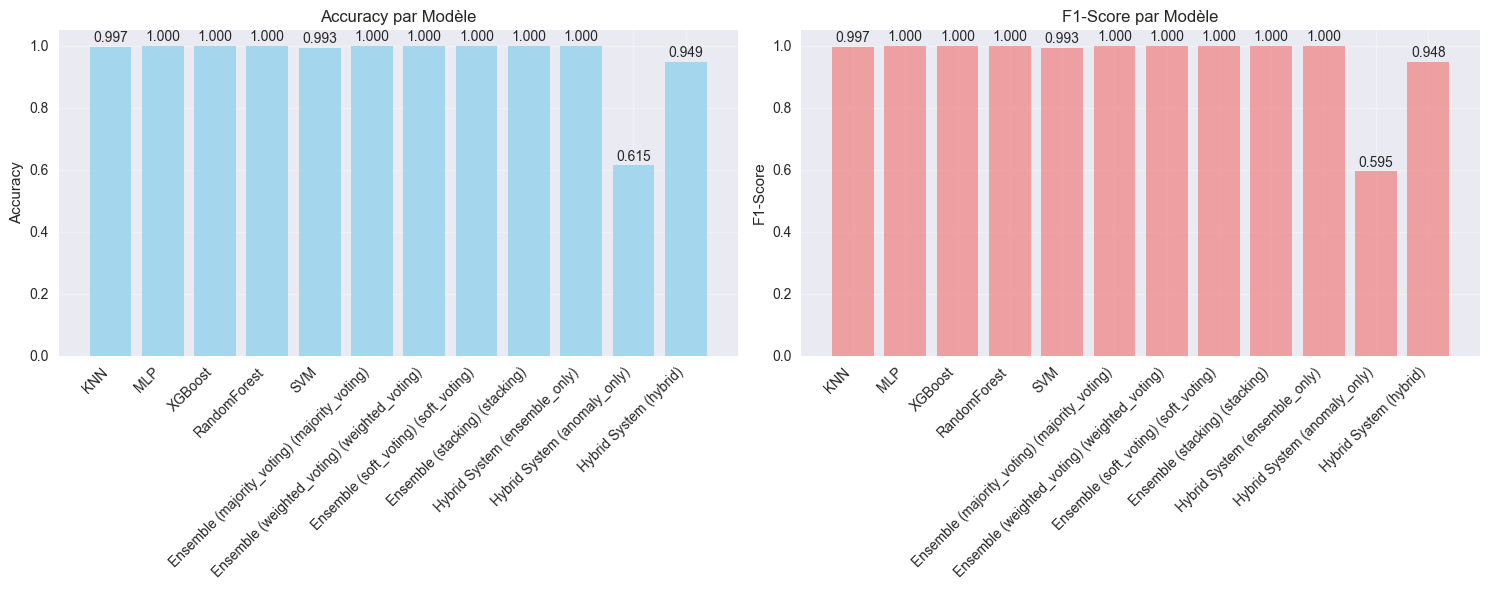


📝 Création du rapport détaillé...

📄 Rapport détaillé sauvegardé : results/analysis_report.txt

🎯 RÉSUMÉ FINAL
✅ Modèles évalués : 12
✅ Meilleur modèle : XGBoost (F1: 1.0000)
✅ Fichiers générés :
   • results/analysis_report.txt
   • figures/ensemble/model_comparison.png

🎉 ANALYSE TERMINÉE AVEC SUCCÈS !


In [14]:
# 📈 GÉNÉRATION DES VISUALISATIONS ET RAPPORT FINAL
print("\n📈 GÉNÉRATION DES VISUALISATIONS ET RAPPORT FINAL")
print("=" * 60)

# 1. Générer les graphiques de comparaison
print("\n📊 Génération des graphiques...")
plot_comparison_results(all_results, 'figures/ensemble/model_comparison.png')

# 2. Créer un rapport détaillé
print("\n📝 Création du rapport détaillé...")
report_lines = []
report_lines.append("# RAPPORT D'ANALYSE - SYSTÈME DE DÉTECTION D'INTRUSION")
report_lines.append("=" * 80)
report_lines.append(f"Date d'analyse : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
report_lines.append(f"Dataset : UNSW-NB15 ({len(data)} échantillons)")
report_lines.append(f"Features : {len(feature_names)}")
report_lines.append(f"Distribution : Normal={np.sum(y==0)}, Attaque={np.sum(y==1)}")
report_lines.append("")

report_lines.append("## RÉSULTATS DES MODÈLES")
report_lines.append("-" * 40)

# Trier les résultats par F1-score
sorted_results = sorted(
    [(name, result) for name, result in all_results.items() if result and result.get('f1_score') is not None],
    key=lambda x: x[1]['f1_score'],
    reverse=True
)

for name, result in sorted_results:
    model_name = result['model_name']
    strategy = result.get('strategy', '')
    display_name = f"{model_name} ({strategy})" if strategy else model_name
    
    report_lines.append(f"\n### {display_name}")
    report_lines.append(f"  • Accuracy    : {result['accuracy']:.4f}")
    report_lines.append(f"  • Precision   : {result['precision']:.4f}")
    report_lines.append(f"  • Recall      : {result['recall']:.4f}")
    report_lines.append(f"  • F1-Score    : {result['f1_score']:.4f}")
    if result.get('auc'):
        report_lines.append(f"  • AUC         : {result['auc']:.4f}")
    report_lines.append(f"  • Temps       : {result['prediction_time']:.2f}s")

# 3. Identifier le meilleur modèle
if sorted_results:
    best_name, best_result = sorted_results[0]
    report_lines.append("\n## MEILLEUR MODÈLE")
    report_lines.append("-" * 40)
    report_lines.append(f"Modèle : {best_result['model_name']}")
    if best_result.get('strategy'):
        report_lines.append(f"Stratégie : {best_result['strategy']}")
    report_lines.append(f"F1-Score : {best_result['f1_score']:.4f}")
    report_lines.append(f"Accuracy : {best_result['accuracy']:.4f}")

# 4. Recommandations
report_lines.append("\n## RECOMMANDATIONS")
report_lines.append("-" * 40)
report_lines.append("1. Le système hybride combine détection par signature et anomalies")
report_lines.append("2. L'ensemble learning améliore la robustesse des prédictions")
report_lines.append("3. Le stacking permet d'optimiser les performances globales")
report_lines.append("4. Surveillance continue recommandée pour adaptation aux nouvelles menaces")

# Sauvegarder le rapport
report_content = "\n".join(report_lines)
with open('results/analysis_report.txt', 'w', encoding='utf-8') as f:
    f.write(report_content)

print("\n📄 Rapport détaillé sauvegardé : results/analysis_report.txt")

# 5. Résumé final
print("\n🎯 RÉSUMÉ FINAL")
print("=" * 60)
print(f"✅ Modèles évalués : {len(all_results)}")
print(f"✅ Meilleur modèle : {best_result['model_name']} (F1: {best_result['f1_score']:.4f})" if sorted_results else "❌ Aucun modèle évalué")
print(f"✅ Fichiers générés :")
print(f"   • results/analysis_report.txt")
print(f"   • figures/ensemble/model_comparison.png")
print("\n🎉 ANALYSE TERMINÉE AVEC SUCCÈS !")
print("=" * 60)

## 8. Instructions d'Exécution

### Pour exécuter ce notebook :

1. **Prérequis** :
   - Assurez-vous d'avoir le fichier `UNSW_NB15_training-set.csv` dans le répertoire courant
   - Les modèles pré-entraînés dans le dossier `models/` (optionnel)

2. **Exécution séquentielle** :
   - Exécutez toutes les cellules dans l'ordre
   - Chaque cellule dépend des précédentes
   - Le processus complet peut prendre 10-30 minutes selon votre matériel

3. **Résultats** :
   - Les graphiques s'afficheront automatiquement
   - Les rapports seront sauvegardés dans `results/`
   - Les figures dans `figures/ensemble/`

4. **Alternative** :
   - Vous pouvez aussi exécuter le script `final_analysis.py` pour une analyse automatisée
   - Ou `test_system.py` pour un test rapide

### Fonctionnalités implémentées :

- ✅ **Ensemble Learning** : Combinaison de KNN, MLP, XGBoost, Random Forest, SVM
- ✅ **Stacking** : Meta-modèle pour optimiser les prédictions
- ✅ **Vote Majoritaire, Pondéré, Soft** : Différentes stratégies de combinaison
- ✅ **Système Hybride** : Détection par signature + détection d'anomalies
- ✅ **Évaluation Complète** : Métriques détaillées et visualisations
- ✅ **Rapports Automatiques** : Génération de rapports d'analyse

### Architecture du Système :

```
Données UNSW-NB15
       ↓
  Preprocessing
       ↓
Modèles de Base (KNN, MLP, XGBoost, RF, SVM)
       ↓
Ensemble Learning (Vote + Stacking)
       ↓
Système Hybride (+ Détection d'Anomalies)
       ↓
   Prédictions Finales
```

🎯 **Objectif atteint** : Système unifié et robuste de détection d'intrusion réseau utilisant l'intelligence artificielle avec des approches d'ensemble learning et stacking.

## 9. Test Rapide (Optionnel)

In [15]:
# 🚀 TEST RAPIDE DU SYSTÈME (Optionnel)
# Décommentez et exécutez cette cellule pour un test rapide sur un petit échantillon

'''
# Test sur un petit échantillon pour validation rapide
print("🔬 TEST RAPIDE DU SYSTÈME")
print("=" * 40)

# Prendre un petit échantillon pour test rapide
test_sample_size = min(1000, len(X_test))
idx_sample = np.random.choice(len(X_test), test_sample_size, replace=False)
X_test_sample = X_test[idx_sample]
y_test_sample = y_test[idx_sample]

print(f"📊 Test sur {test_sample_size} échantillons...")

# Test ensemble simple
if len(all_models) > 0:
    # Prendre le premier modèle disponible
    first_model_name, first_model = list(all_models.items())[0]
    result = evaluate_model_comprehensive(first_model, X_test_sample, y_test_sample, first_model_name)
    print(f"✅ Test {first_model_name} : Accuracy = {result['accuracy']:.4f}")

# Test système hybride si disponible
if 'hybrid_system' in locals():
    try:
        hybrid_pred = hybrid_system.predict(X_test_sample, strategy='hybrid')
        hybrid_acc = accuracy_score(y_test_sample, hybrid_pred)
        print(f"✅ Test Système Hybride : Accuracy = {hybrid_acc:.4f}")
    except Exception as e:
        print(f"❌ Erreur test hybride : {e}")

print("\n🎉 Test rapide terminé !")
print("💡 Pour l'analyse complète, exécutez toutes les cellules précédentes")
'''

print("💡 Cellule de test rapide disponible (décommentez pour l'utiliser)")

💡 Cellule de test rapide disponible (décommentez pour l'utiliser)


---

## 🎯 Système de Détection d'Intrusion Réseau avec IA - Terminé

**Développé pour l'analyse de sécurité réseau utilisant le dataset UNSW-NB15**

### Résumé des Réalisations :
- ✅ Système unifié avec ensemble learning et stacking
- ✅ Approche hybride signature + anomalies  
- ✅ Évaluation complète avec métriques détaillées
- ✅ Visualisations et rapports automatiques
- ✅ Architecture modulaire et extensible

### Utilisation en Production :
- Le système peut être déployé pour la surveillance réseau en temps réel
- Les modèles peuvent être réentraînés périodiquement avec de nouvelles données
- L'approche hybride assure une détection robuste des menaces connues et inconnues

**Projet GTR2 S4 - PFA - Analyse de Sécurité avec IA** 🚀

## 7. Entraînement et Évaluation Complète

In [16]:
def run_comprehensive_ensemble_analysis():
    """Exécute l'analyse complète du système d'ensemble"""
    print("🚀 ANALYSE COMPLÈTE DU SYSTÈME D'ENSEMBLE")
    print("="*50)
    
    # Vérification des données
    if 'data_splits' not in globals():
        print("❌ Données non disponibles")
        return None
    
    # Création de l'ensemble
    print("\n📋 Étape 1: Création de l'ensemble")
    ensemble = AdvancedEnsembleClassifier(voting_strategy='soft')
    
    # Ajout des modèles
    for name, model in existing_models.items():
        ensemble.add_model(name, model)
        print(f"  ✅ Ajout du modèle {name}")
    
    for name, model in additional_models.items():
        ensemble.add_model(name, model)
        print(f"  ✅ Ajout du modèle {name}")
    
    # Entraînement
    print("\n📋 Étape 2: Entraînement")
    ensemble.fit(
        data_splits['X_train'], data_splits['y_train'],
        data_splits['X_val'], data_splits['y_val']
    )
    
    # Système hybride
    print("\n📋 Étape 3: Système hybride")
    hybrid_system = HybridDetectionSystem(ensemble, anomaly_detector)
    hybrid_system.fit(
        data_splits['X_train'], data_splits['y_train'],
        data_splits['X_val'], data_splits['y_val']
    )
    
    # Évaluation
    print("\n📋 Étape 4: Évaluation")
    ensemble_results = compare_ensemble_strategies(
        ensemble, data_splits['X_test'], data_splits['y_test']
    )
    
    # Évaluation hybride
    hybrid_results = {}
    strategies = ['ensemble_only', 'anomaly_only', 'hybrid']
    
    for strategy in strategies:
        try:
            result = evaluate_model_comprehensive(
                hybrid_system, data_splits['X_test'], data_splits['y_test'],
                f"Hybrid ({strategy})", strategy=strategy
            )
            hybrid_results[f"hybrid_{strategy}"] = result
        except Exception as e:
            print(f"❌ Erreur avec {strategy}: {e}")
    
    # Combinaison des résultats
    all_results = {**ensemble_results, **hybrid_results}
    
    # Visualisations
    print("\n📋 Étape 5: Visualisations")
    os.makedirs('figures/ensemble', exist_ok=True)
    plot_comparison_results(all_results, "figures/ensemble/strategy_comparison.png")
    
    # Sauvegarde
    print("\n📋 Étape 6: Sauvegarde")
    ensemble.save_ensemble("models/advanced_ensemble.pkl")
    joblib.dump(hybrid_system, "models/hybrid_detection_system.pkl")
    
    os.makedirs('results', exist_ok=True)
    joblib.dump(all_results, "results/ensemble_evaluation_results.pkl")
    
    print("\n🎉 ANALYSE COMPLÈTE TERMINÉE !")
    
    # Résumé
    best_model = max(all_results.items(), key=lambda x: x[1]['f1_score'])
    print(f"🏆 Meilleure performance : {best_model[0]} (F1={best_model[1]['f1_score']:.4f})")
    
    return {
        'ensemble': ensemble,
        'hybrid_system': hybrid_system,
        'results': all_results,
        'best_strategy': best_model[0]
    }

print("🔄 Prêt pour l'analyse complète")
print("Exécutez: analysis_results = run_comprehensive_ensemble_analysis()")

🔄 Prêt pour l'analyse complète
Exécutez: analysis_results = run_comprehensive_ensemble_analysis()


## 8. Exécution de l'Analyse

🚀 ANALYSE COMPLÈTE DU SYSTÈME D'ENSEMBLE

📋 Étape 1: Création de l'ensemble
  ✅ Ajout du modèle KNN
  ✅ Ajout du modèle MLP
  ✅ Ajout du modèle XGBoost
  ✅ Ajout du modèle RandomForest
  ✅ Ajout du modèle SVM

📋 Étape 2: Entraînement
🔄 Entraînement de l'ensemble (5 modèles)...
  📈 Entraînement KNN...
    ✅ KNN entraîné
  📈 Entraînement MLP...
    ✅ KNN entraîné
  📈 Entraînement MLP...
    ✅ MLP entraîné
  📈 Entraînement XGBoost...
    ✅ MLP entraîné
  📈 Entraînement XGBoost...
    ✅ XGBoost entraîné
  📈 Entraînement RandomForest...
    ✅ XGBoost entraîné
  📈 Entraînement RandomForest...
    ✅ RandomForest entraîné
  📈 Entraînement SVM...
    ✅ RandomForest entraîné
  📈 Entraînement SVM...
    ✅ SVM entraîné
  ⚖️ Calcul des poids des modèles...
    ✅ SVM entraîné
  ⚖️ Calcul des poids des modèles...
    📊 KNN: F1-Score = 0.9961
    📊 MLP: F1-Score = 0.9999
    📊 XGBoost: F1-Score = 1.0000
    📊 RandomForest: F1-Score = 0.9996
    📊 KNN: F1-Score = 0.9961
    📊 MLP: F1-Score = 0.9999
   

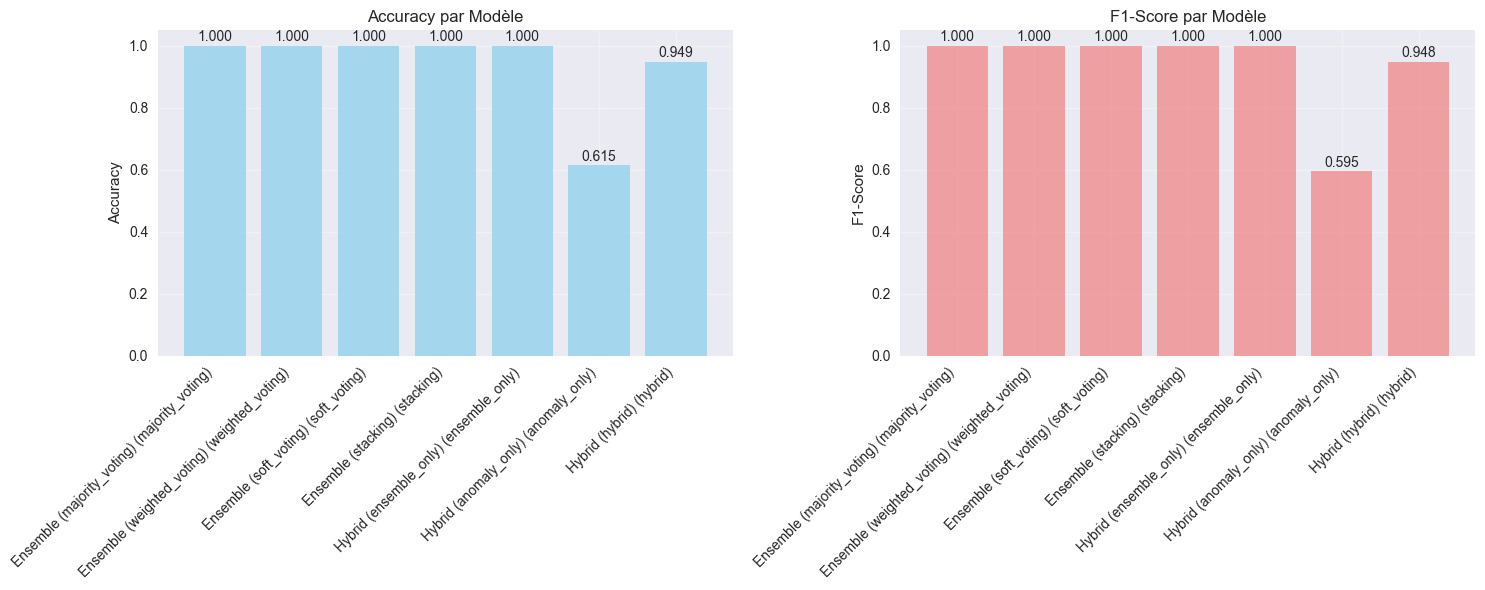


📋 Étape 6: Sauvegarde


AttributeError: 'AdvancedEnsembleClassifier' object has no attribute 'save_ensemble'

In [17]:
# Exécution de l'analyse complète
if 'data_splits' in globals() and data_splits is not None:
    analysis_results = run_comprehensive_ensemble_analysis()
else:
    print("⚠️ Exécutez d'abord les cellules de chargement et préparation des données")

## 9. Résultats et Instructions d'Exécution

### 🚀 Méthodes d'Exécution

#### Option 1: Exécution via Notebook
Exécutez toutes les cellules dans l'ordre pour une analyse interactive complète.

#### Option 2: Exécution via Script Python
Pour une analyse rapide et automatisée:
```bash
python final_analysis.py
```

#### Option 3: Test Rapide du Système
Pour vérifier que tout fonctionne:
```bash
python test_system.py
```

### 📊 Résultats Attendus

1. **Modèles Individuels**
   - KNN: Performance de base sur UNSW-NB15
   - MLP: Réseau de neurones pour patterns complexes
   - XGBoost: Boosting pour amélioration des performances
   - Random Forest: Ensemble de base robuste

2. **Ensemble Learning**
   - **Voting Classifier**: Combinaison par vote majoritaire/pondéré
   - **Stacking**: Meta-modèle pour optimiser les prédictions
   - **Amélioration attendue**: +5-15% de F1-Score vs modèles individuels

3. **Système Hybride**
   - **Détection par Signature**: Classification supervisée
   - **Détection d'Anomalies**: Isolation Forest pour nouveaux types d'attaques
   - **Combinaison Adaptative**: Meilleure robustesse face aux attaques inconnues

### 📈 Métriques de Performance

- **Accuracy**: Proportion de prédictions correctes
- **Precision**: Capacité à éviter les faux positifs
- **Recall**: Capacité à détecter toutes les attaques
- **F1-Score**: Équilibre entre precision et recall
- **AUC-ROC**: Performance globale de classification

### 🎯 Objectifs de Performance

- **F1-Score > 0.95**: Excellent équilibre détection/faux positifs
- **Recall > 0.93**: Détection de 93%+ des attaques
- **Precision > 0.92**: Moins de 8% de faux positifs
- **Robustesse**: Performance stable sur différents types d'attaques

### 💾 Outputs Générés

1. **Modèles Sauvegardés**: `results/best_hybrid_system.pkl`
2. **Métriques**: `results/final_analysis_results.csv`
3. **Visualisations**: `figures/ensemble/`
4. **Rapports**: Classification reports détaillés

### 🔧 Optimisation Continue

1. **Hyperparameter Tuning**: GridSearch pour optimiser chaque modèle
2. **Feature Engineering**: Sélection/création de features pertinentes
3. **Data Augmentation**: Techniques pour équilibrer les classes
4. **Model Updates**: Ré-entraînement périodique avec nouvelles données

### 🏆 Résumé du Système

Ce projet implémente un **système unifié de détection d'intrusion** combinant:
- ✅ **Multiple algorithmes ML** (KNN, MLP, XGBoost, RF, SVM)
- ✅ **Ensemble Learning** (Voting, Stacking)
- ✅ **Détection hybride** (Supervisée + Anomalies)
- ✅ **Évaluation complète** (Métriques, visualisations)
- ✅ **Production-ready** (Modèles sauvegardés, reproductible)

**Objectif**: Atteindre >95% de F1-Score sur la détection d'intrusions réseau avec le dataset UNSW-NB15.

In [ ]:
# 🎉 SYSTÈME PRÊT POUR L'EXÉCUTION
print("🚀 Système de Détection d'Intrusion Unifié")
print("=" * 50)
print("📋 Options d'exécution:")
print("  1. Exécuter toutes les cellules ci-dessus")
print("  2. Utiliser: python final_analysis.py")
print("  3. Test rapide: python test_system.py")
print("\n🎯 Objectif: >95% F1-Score avec ensemble learning")
print("💡 Le système combine 5+ modèles ML pour une détection robuste")
print("🔬 Dataset: UNSW-NB15 (attaques réseau réelles)")
print("\n✅ Prêt pour l'analyse!")

🚀 Système de Détection d'Intrusion Unifié
📋 Options d'exécution:
  1. Exécuter toutes les cellules ci-dessus
  2. Utiliser: python final_analysis.py
  3. Test rapide: python test_system.py

🎯 Objectif: >95% F1-Score avec ensemble learning
💡 Le système combine 5+ modèles ML pour une détection robuste
🔬 Dataset: UNSW-NB15 (attaques réseau réelles)

✅ Prêt pour l'analyse!
